In [1]:
# this chemkin file is from the cti generated by rmg

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
%matplotlib inline

gas = ct.Solution('./chem.cti','gas')
surf = ct.Interface('./chem.cti','surface1', [gas])
print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_n2 = gas.species_index('N2')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

/home/mazeau.e/Code/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/pyt

This mechanism contains 22 gas reactions and 79 surface reactions


  1.000000e-04    0.099949    0.099902    0.800039
  2.238721e-04    0.099916    0.099878    0.800029
  5.011872e-04    0.099873    0.099845    0.800014
  1.122018e-03    0.099827    0.099805    0.799994
  2.511886e-03    0.099776    0.099755    0.799967
  5.623413e-03    0.099710    0.099683    0.799929
  1.258925e-02    0.099620    0.099578    0.799879
  2.818383e-02    0.099493    0.099421    0.799811
  6.309573e-02    0.099295    0.099164    0.799712
  1.412538e-01    0.098940    0.098683    0.799545
  3.162278e-01    0.098207    0.097669    0.799218
  7.079458e-01    0.096629    0.095419    0.798558
  1.584893e+00    0.093321    0.090435    0.797371
  3.548134e+00    0.086810    0.079649    0.795745
  7.943282e+00    0.075395    0.058353    0.794631
  1.778279e+01    0.060769    0.028769    0.794874
  3.981072e+01    0.052088    0.011154    0.795061
  8.912509e+01    0.048997    0.005395    0.794753
  1.995262e+02    0.047536    0.003103    0.794296
  4.466836e+02    0.046569    0

Text(0.5,0,u'Time(s)')

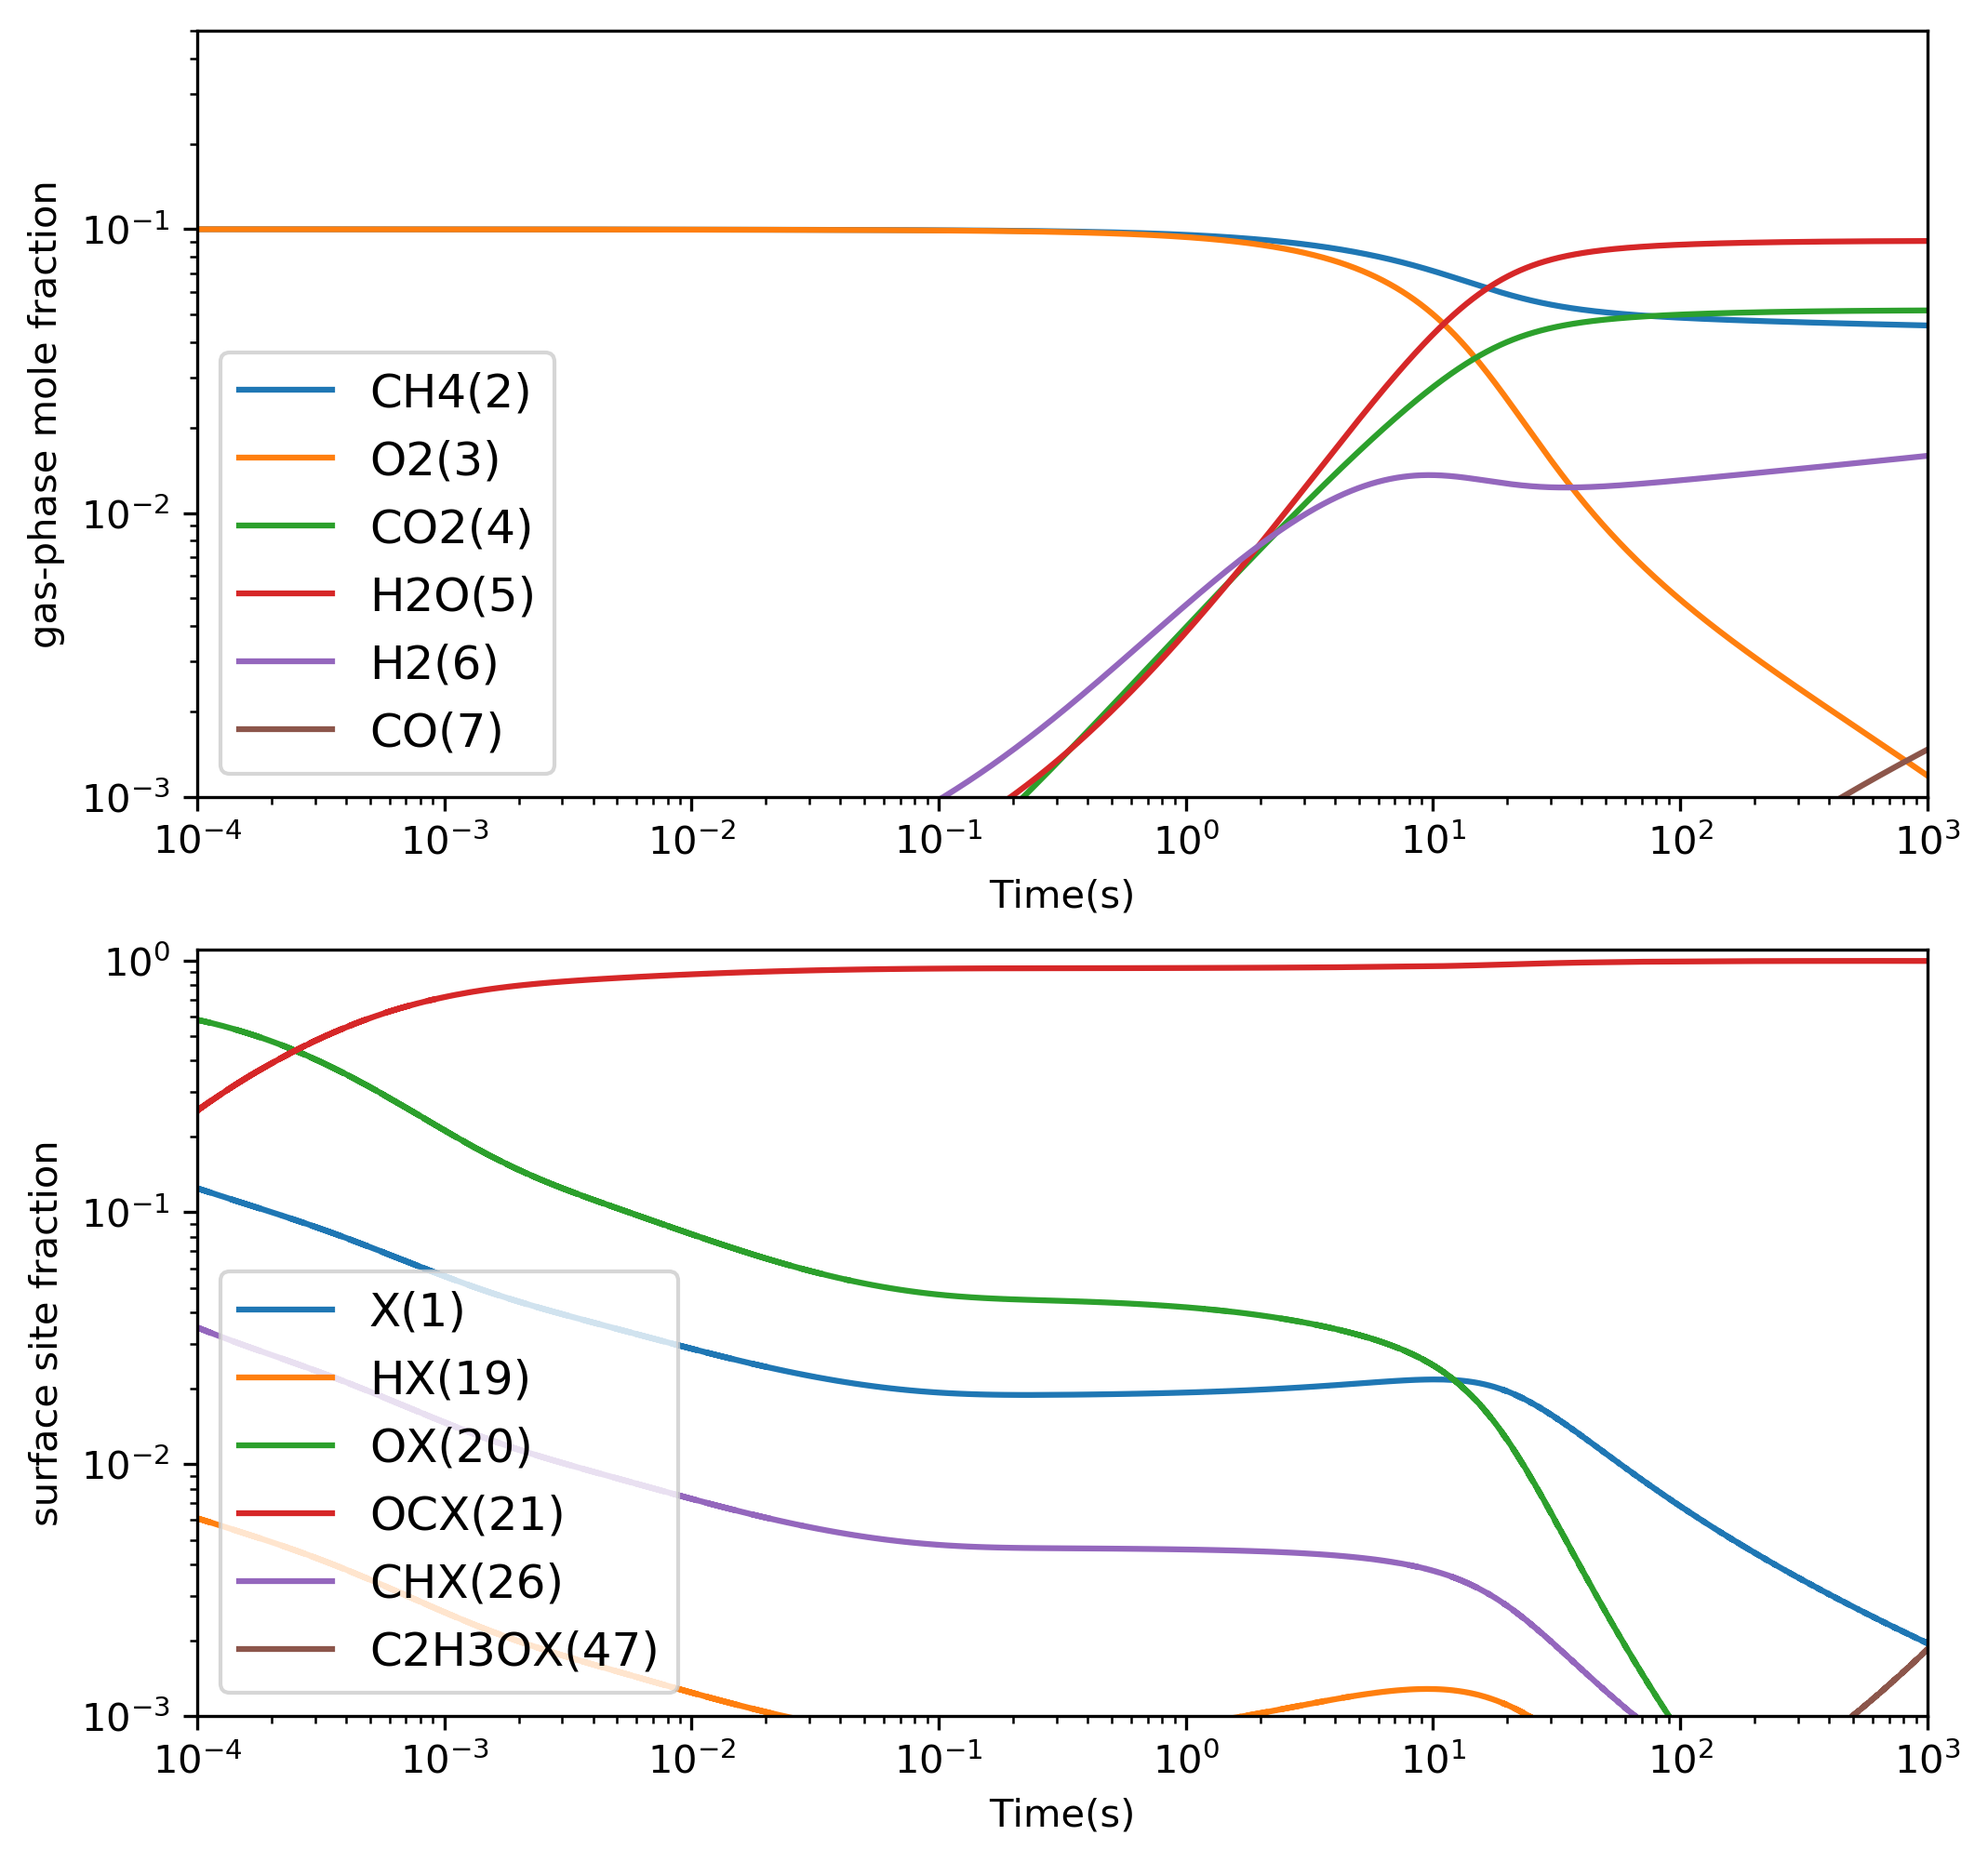

In [2]:
#######################################################################
# Input Parameters
#######################################################################

volume = 1.0
cat_area_per_vol = 1.0E2 #I made this up!

cat_area = cat_area_per_vol * volume

#initial conditions
T0 = 800.
P0 = 1.0 #bar
#initial composition (gas mol fraction)
CH4_0 = 0.1
O2_0 = 0.1
N2_0 = 0.8
CO2_0 = 0.

gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0, 'CO2(4)':CO2_0}
          #Temp, Pressure, mole fraction
surf.TP = T0, P0 * ct.one_atm
surf.coverages = {'X(1)':1.0}
#surf.coverages = {'PT(S)':0.9, 'O(S)':0.1}

r = ct.IdealGasConstPressureReactor(gas, energy='off')
r.volume = volume
rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-18

#rxn_time = np.linspace(1E-12, 5, 10001) #
rxn_time = np.logspace(-4, 3, 10001) #from 0s to 100s, log spacing

gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
surf_site_fracs = np.zeros([surf.n_species, len(rxn_time)])
temperature = np.zeros(len(rxn_time))    
pressure = np.zeros(len(rxn_time))   

for i in range(len(rxn_time)):
    time = rxn_time[i] #define time in the reactor
    sim.advance(time) #Advance the simulation to next set time
    temperature[i] = gas.T
    pressure[i] = gas.P/ct.one_atm
    gas_mole_fracs[:,i] = gas.X #
    surf_site_fracs[:,i] = surf.coverages #
    if not i % 500:
        print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(time, *gas['CH4(2)','O2(3)','N2'].X))



#sim.advance_to_steady_state()
#print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(sim.time, *gas['CH4','H2','CO'].X))    
    
CH4_ref = gas_mole_fracs[i_ch4,:]

#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

y_min = 1E-3

for i in range(gas.n_species):
    if i != i_n2:
        if np.max(gas_mole_fracs[i,:]) > y_min:
            ax0.loglog(rxn_time, gas_mole_fracs[i,:], label=gas.species_name(i) )

for i in range(surf.n_species):
    if np.max(surf_site_fracs[i,:]) > y_min:
        ax1.loglog(rxn_time, surf_site_fracs[i,:], label=surf.species_name(i) )
            
ax0.legend(loc='lower left', fontsize = 12)
ax1.legend(loc='lower left', fontsize = 12)

ax0.set_ylabel("gas-phase mole fraction")
ax0.set_ylim(y_min,0.5)
ax0.set_xlim(1.0E-4,max(rxn_time))
ax1.set_xlim(1.0E-4,max(rxn_time))
ax0.set_xlabel("Time(s)")
ax1.set_ylabel("surface site fraction")
#ax0.xaxis.set_major_locator(MaxNLocator(6))
#ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
#ax0.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylim(y_min, 1.1 )
ax1.set_xlabel("Time(s)")


In [3]:
# Set the value of the perturbation
dk = 1.0e-2
# create the array to hold the sensitivty at each time step
Sensitivity = np.zeros([surf.n_reactions,len(rxn_time)])

#cycle through each reaction
for m in range(surf.n_reactions):
    surf.set_multiplier(1.0) # reset all multipliers  
    surf.set_multiplier(1+dk, m) # perturb reaction m
    
    gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0}
              #Temp, Pressure, mole fraction
    surf.TP = T0, P0 * ct.one_atm
    surf.coverages = {'X(1)':1.0}
    
    r = ct.IdealGasConstPressureReactor(gas, energy='off')
    r.volume = volume
    rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area


    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12


    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-12
    sim.atol = 1.0e-18
    gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
    temperature = np.zeros(len(rxn_time))    
    pressure = np.zeros(len(rxn_time))   

    for i in range(len(rxn_time)):
        time = rxn_time[i] #define time in the reactor
        sim.advance(time) #Advance the simulation to next set time
        temperature[i] = gas.T
        pressure[i] = gas.P/ct.one_atm
        gas_mole_fracs[:,i] = gas.X #[mol.frac,nth reactor]
    # here is the new output
    CH4_new = gas_mole_fracs[i_ch4,:]


    Sens = (CH4_new-CH4_ref)/(CH4_ref*dk)
    max_sensitivity = max(max(Sens),-min(Sens))
#    if (1==0):
#        if (max_sensitivity>0.01):
#            print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
#    else:
    print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
    Sensitivity[m,:] = Sens
    
surf.set_multiplier(1.0)

 

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
0 CH4(2) + X(1) <=> CH4X(33) 0.00
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.35
2 C2H6(8) + 2 X(1) <=> 2 CH3X(22) 0.00
3 CH3(10) + X(1) <=> CH3X(22) 0.00
4 H2(6) + 2 X(1) <=> 2 HX(19) 0.01
5 CH3X(22) + HX(19) <=> CH4(2) + 2 X(1) 0.03
6 H(12) + X(1) <=> HX(19) 0.00
7 CH2X(134) + HX(19) <=> CH3X(22) + X(1) 0.00
8 CHX(26) + HX(19) <=> CH2X(134) + X(1) 0.00
9 2 CH2X(134) <=> CH3X(22) + CHX(26) 0.00
10 CH3X(22) + HOX(23) <=> CH4(2) + OX(20) + X(1) 0.45
11 HOX(23) + HX(19) <=> H2O(5) + 2 X(1) 0.07
12 2 HOX(23) <=> H2O(5) + OX(20) + X(1) 0.00
13 CH3OH(14) + 2 X(1) <=> CH3X(22) + HOX(23) 0.00
14 OH(17) + X(1) <=> HOX(23) 0.00
15 CH2X(134) + HOX(23) <=> CH3X(22) + OX(20) 0.00
16 HOX(23) + X(1) <=> HX(19) + OX(20) 0.00
17 CHX(26) + HOX(23) <=> CH2X(134) + OX(20) 0.00
18 H2(6) + X(1) <=> H2X(36) 0.00
19 CHX(26) + OX(20) <=> CXHO(27) + X(1) 0.00
20 CH2O(9) + 2 X(1) <=> CXHO

Text(0,0.5,u'Sensitivity Coefficient')

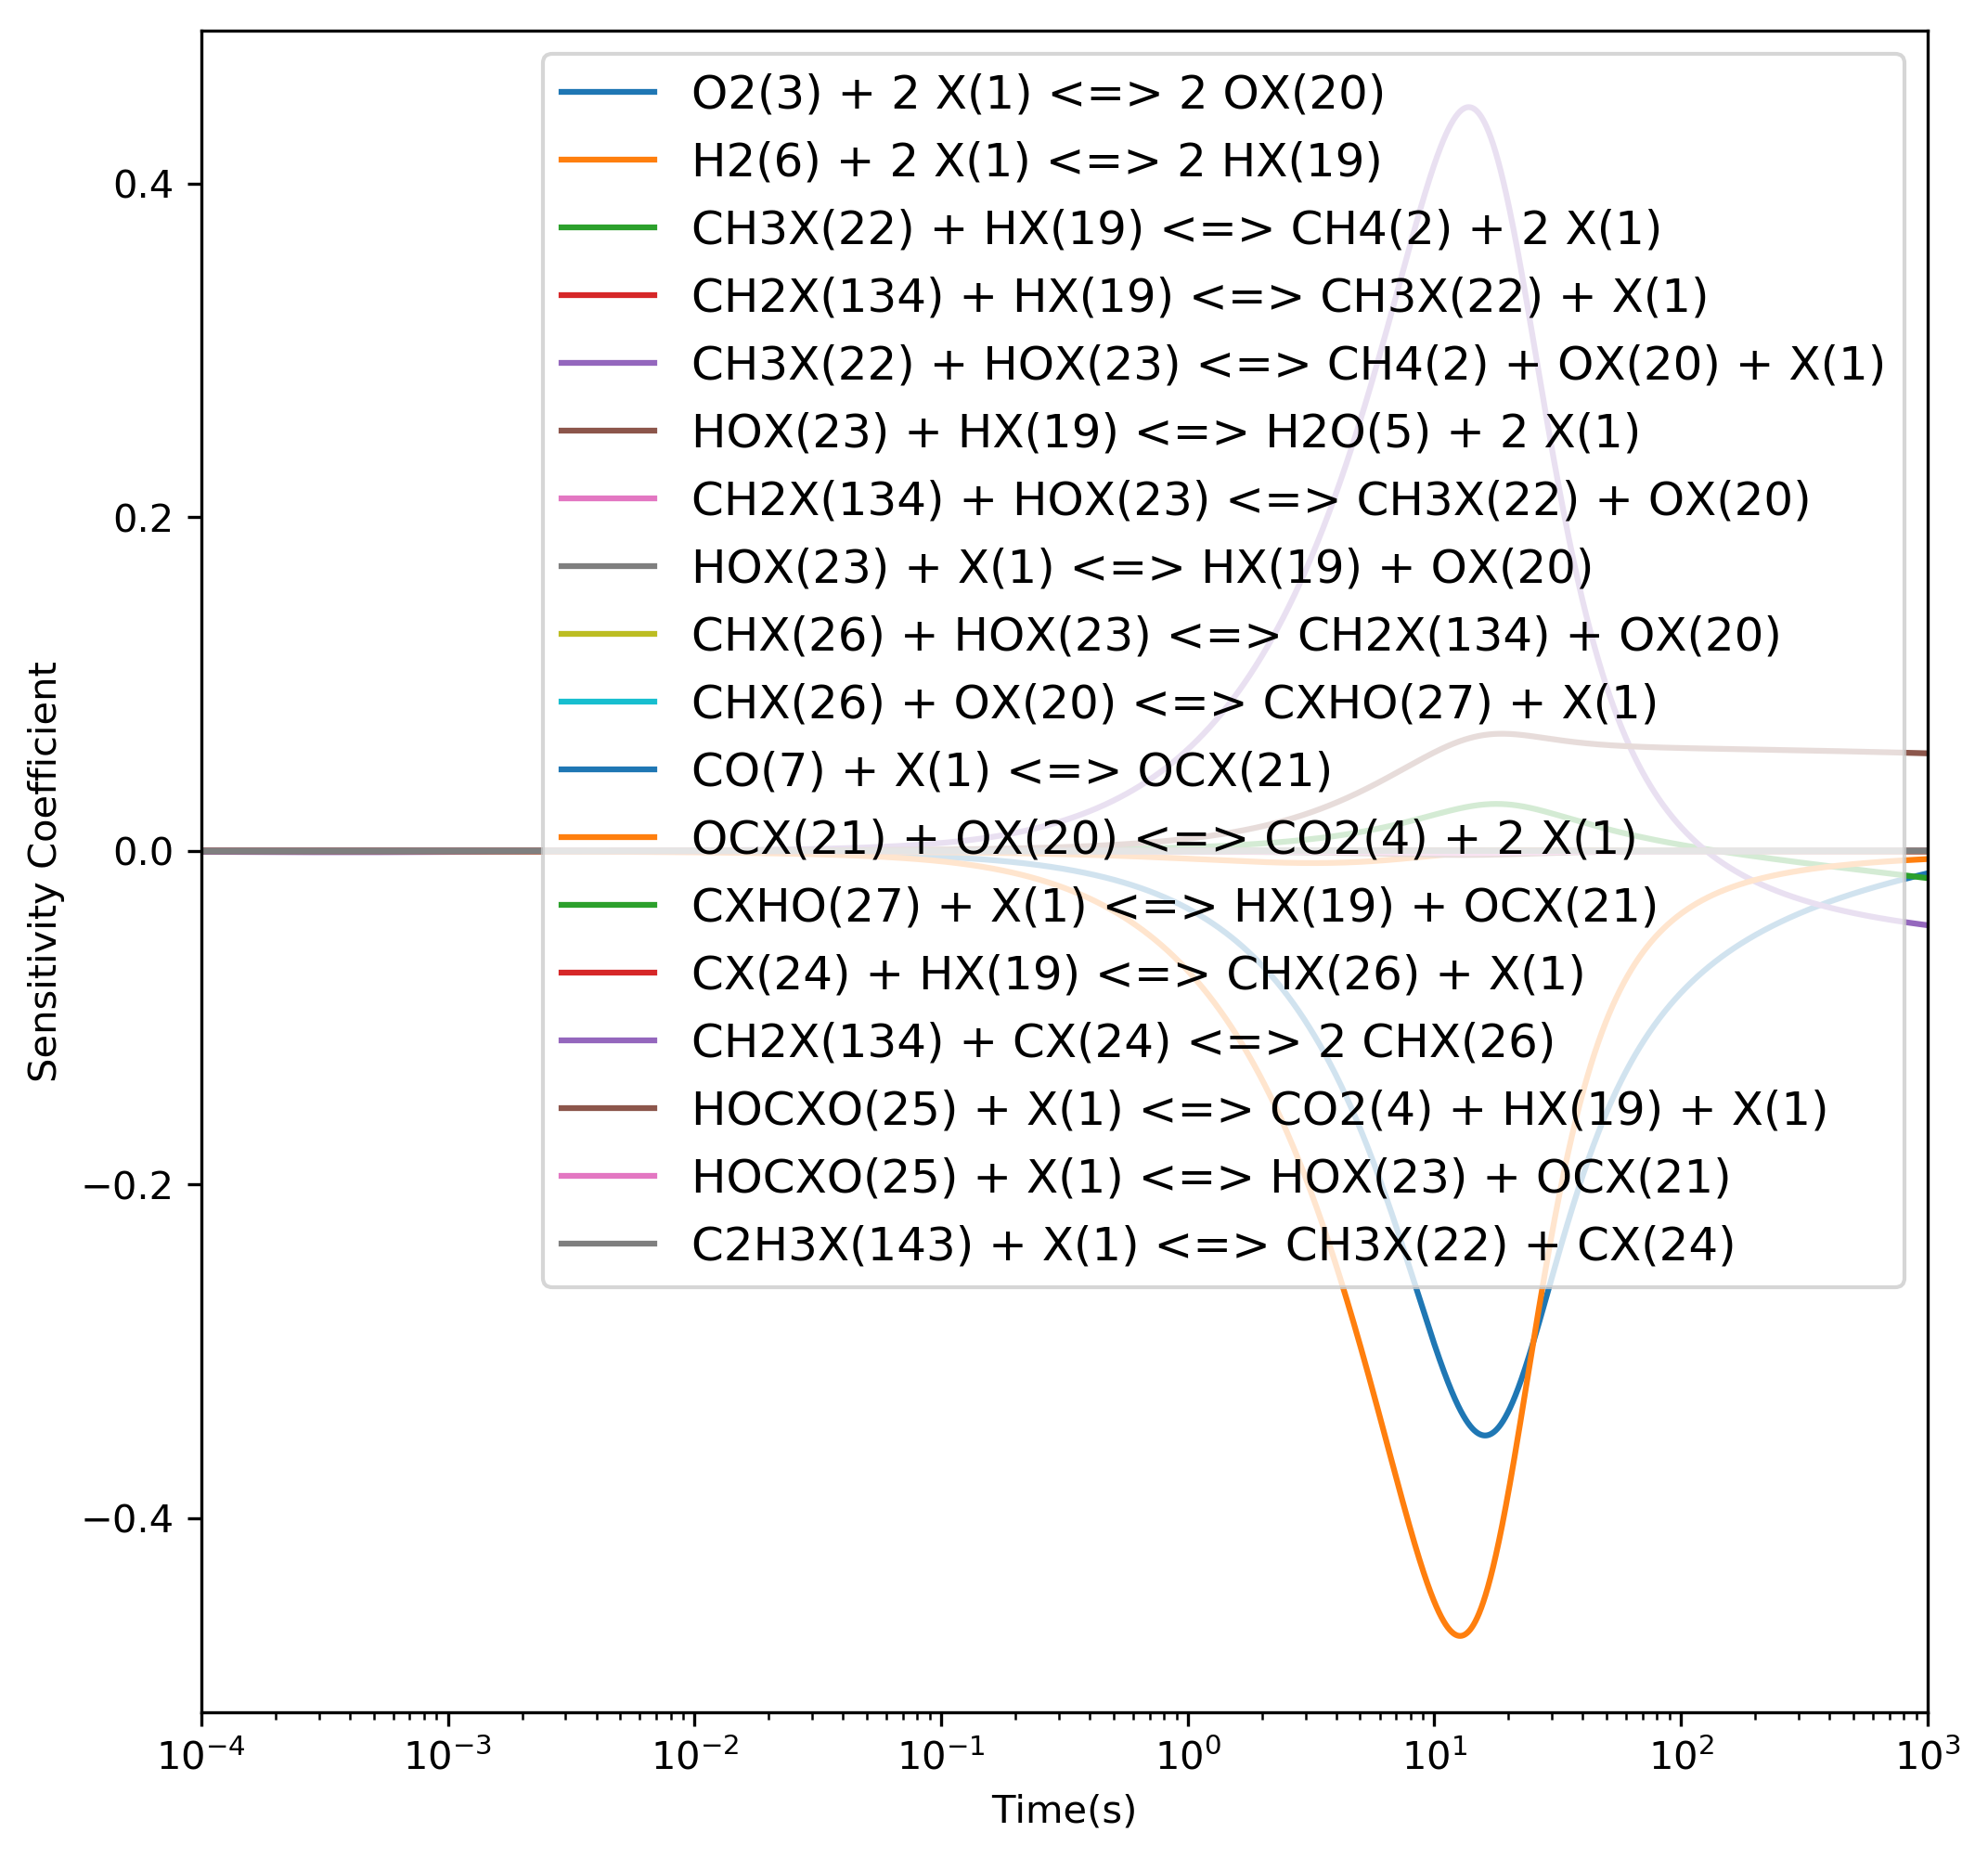

In [4]:
#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])


for m in range(surf.n_reactions):
    y_max = 0.00001
    if (1==1):
        if max(Sensitivity[m,:])>y_max or min(Sensitivity[m,:])<-y_max:
            lab = surf.reaction_equations()[m]
            ax0.semilogx(rxn_time, Sensitivity[m,:], label=lab )
    else:
        if max(Normed_sensitivity[m,:])>y_max or min(Normed_sensitivity[m,:])<-y_max:
            lab = surf.reaction_equations()[m]
            ax0.semilogx(rxn_time, Normed_sensitivity[m,:], label=lab )
        
ax0.legend(loc='best', fontsize = 12)   
ax0.set_xlim(rxn_time[1], rxn_time[-1] )

ax0.set_xlabel("Time(s)")
ax0.set_ylabel("Sensitivity Coefficient")

In [5]:
# now integrate with respect to time
from numpy import trapz

# for m in range(surf.n_reactions):
#     ans = trapz(Sensitivity[m,:], rxn_time)#/max(rxn_time)
#     if ans>1E-4:
#         print "%d %s %.5f"%( m, surf.reaction_equations()[m], ans )

n = []
rxns = []
for m in range(surf.n_reactions):
    n.append(trapz(Sensitivity[m,:], rxn_time))#/max(rxn_time)
    rxns.append(surf.reaction_equations()[m])

ans = dict(zip(rxns,n))
sorted_ans = sorted(ans.items(), key=operator.itemgetter(1), reverse=True)

for x in sorted_ans:
    print '%s %.4f'%(x)

HOX(23) + HX(19) <=> H2O(5) + 2 X(1) 59.8083
CHX(26) + HOX(23) <=> CH2X(134) + OX(20) 0.0471
HOX(23) + X(1) <=> HX(19) + OX(20) 0.0250
C2H3X(143) + X(1) <=> CH3X(22) + CX(24) 0.0226
CO(7) + X(1) <=> OCX(21) 0.0020
C2H3OX(47) + X(1) <=> CH3X(22) + OCX(21) 0.0017
CH2X(134) + HOX(23) <=> CH3X(22) + OX(20) 0.0004
2 HOX(23) <=> H2O(5) + OX(20) + X(1) 0.0003
CH2OX(137) + X(1) <=> CHX(26) + HOX(23) 0.0000
CXHO(27) + OX(20) <=> HOX(23) + OCX(21) 0.0000
CH2OX(137) + OX(20) <=> CHX(26) + HO2X(136) 0.0000
CH2OX(137) + OX(20) <=> CHOX(144) + HOX(23) 0.0000
CHX(26) + HOCXO(25) <=> CH2OX(137) + OCX(21) 0.0000
CH2O(9) + X(1) <=> CH2OX(40) 0.0000
OH(17) + X(1) <=> HOX(23) 0.0000
C2H4X(135) + CHX(26) <=> C2H3X(143) + CH2X(134) 0.0000
CO(7) + X(1) <=> COX(37) -0.0000
CO2(4) + X(1) <=> CO2X(34) -0.0000
CH2OX(137) + CH2X(134) <=> CH3X(22) + CHOX(144) -0.0000
C2H6(8) + 2 X(1) <=> 2 CH3X(22) -0.0000
H2O(5) + X(1) <=> H2OX(35) -0.0000
CH3OH(14) + X(1) <=> CH3OHX(46) -0.0000
CH3CHO(16) + 2 X(1) <=> C2H3OX(47)

In [6]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in rxns:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

answer = dict(zip(rxns_translated, n))
sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=True)
# for x in sorted_answer:
#     print '%s %.4f'%(x)

There are 2 dupllicate smiles for OX(20):
<Molecule "O=[Ni]">
<Molecule "[O-][Ni]">


In [7]:
# write to csv file
(pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
.to_csv('dict.csv', header=False))
